## Base Model with Data Augmentation

The dataset used for this involves each class having 100 training images and 22 testing images. For training purposes, each configuration is trained on its fixed position (50 images) and +-30 degrees from that fixed poistion (25 images each). For testing purposes the test images are the fixed position(6 images), +-45 degrees around that position (5 images each) and +-90 degrees around that position (3 images each).

Tensorflow 2.8> which is the default installation in Colab does not work with keras.preprocessing, that's why the first thing we do is ensure we have the correct TensorFlow version

In [1]:
#!pip uninstall tensorflow
!pip install tensorflow==2.7.0


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir




--2022-06-22 09:01:06--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.2’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-06-22 09:01:06 (103 MB/s) - ‘helper_functions.py.2’ saved [10246/10246]



Download and unzip images from my Drive

In [3]:
unzip_data("/content/drive/MyDrive/MyModel.zip")


Remove any hidden files in the test/train directories





In [4]:
rmdir /content/MyModel/Train/.ipynb_checkpoints

rmdir: failed to remove '/content/MyModel/Train/.ipynb_checkpoints': No such file or directory


In [5]:
rmdir /content/MyModel/Test/.ipynb_checkpoints

rmdir: failed to remove '/content/MyModel/Test/.ipynb_checkpoints': No such file or directory


In [6]:
walk_through_dir("/content/MyModel")

There are 4 directories and 2 images in '/content/MyModel'.
There are 3 directories and 0 images in '/content/MyModel/val'.
There are 0 directories and 15 images in '/content/MyModel/val/All'.
There are 0 directories and 15 images in '/content/MyModel/val/None'.
There are 0 directories and 15 images in '/content/MyModel/val/One'.
There are 10 directories and 0 images in '/content/MyModel/train'.
There are 0 directories and 100 images in '/content/MyModel/train/All'.
There are 0 directories and 100 images in '/content/MyModel/train/Two'.
There are 0 directories and 100 images in '/content/MyModel/train/None'.
There are 0 directories and 100 images in '/content/MyModel/train/Five'.
There are 0 directories and 100 images in '/content/MyModel/train/One'.
There are 0 directories and 100 images in '/content/MyModel/train/Seven'.
There are 0 directories and 100 images in '/content/MyModel/train/Three'.
There are 0 directories and 100 images in '/content/MyModel/train/Four'.
There are 0 direct

In [7]:
# Create training and test directories
train_dir = "/content/MyModel/train/"
test_dir = "/content/MyModel/test/"

In [8]:
# Creating data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) 

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 1000 files belonging to 10 classes.
Found 220 files belonging to 10 classes.


In [9]:
train_data.class_names

['All', 'Eight', 'Five', 'Four', 'None', 'One', 'Seven', 'Six', 'Three', 'Two']

In [10]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [11]:
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.1),
    preprocessing.RandomZoom(0.1),
    preprocessing.RandomHeight(0.1),
    preprocessing.RandomWidth(0.1),
], name = "data_augmentation")

After varying these parameters and testing them against each pther, it was found that using 0.1-0.2 for each produced optimal results. Manipulating the random flip did not have a significant impact on results.

In [12]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os 
import random

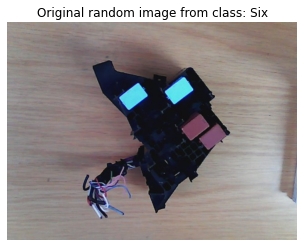

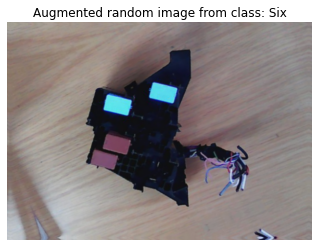

In [13]:
target_class = random.choice(train_data.class_names) #choose a random class
target_dir = "/content/MyModel/train/" +target_class #create teh target directory
os.listdir(target_dir)
random_image = random.choice(os.listdir(target_dir)) #choose random imagefrom target directory
random_image_path = target_dir+"/" + random_image #create chose random image path
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); 

#Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) #data augmentation requires shape (None,height,width,3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) #requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

In [14]:
initial_epochs=5

#setup the input and base model, freezing the base model layers
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#Add in data augmentation Sequential model as layer
x = data_augmentation(inputs)

#Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

#Pool output features of base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

#Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

#compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(lr=0.001),
                metrics = ["accuracy"])

#Fit the model 
history_1 = model_1.fit(train_data,
                                epochs = initial_epochs,
                                steps_per_epoch = len(train_data),
                                validation_data = test_data,
                                validation_steps = int(len(test_data)))
                                #callbacks = [create_tensorboard_callback("transfer_learning", "data_aug")])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/5
32/32 [==============================] - 29s 516ms/step - loss: 1.8271 - accuracy: 0.3940 - val_loss: 1.6168 - val_accuracy: 0.5045
Epoch 2/5
32/32 [==============================] - 8s 239ms/step - loss: 1.1663 - accuracy: 0.7040 - val_loss: 1.3266 - val_accuracy: 0.6045
Epoch 3/5
32/32 [==============================] - 8s 230ms/step - loss: 0.8702 - accuracy: 0.8340 - val_loss: 1.1685 - val_accuracy: 0.6682
Epoch 4/5
32/32 [==============================] - 7s 217ms/step - loss: 0.6949 - accuracy: 0.8910 - val_loss: 1.0760 - val_accuracy: 0.7227
Epoch 5/5
32/32 [==============================] - 7s 204ms/step - loss: 0.5807 - accuracy: 0.9390 - val_loss: 0.9899 - val_accuracy: 0.7500


In [15]:
model_1.evaluate(test_data)

7/7 [==============================] - 1s 77ms/step - loss: 0.9899 - accuracy: 0.7500


[0.9898795485496521, 0.75]

In [16]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).

  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

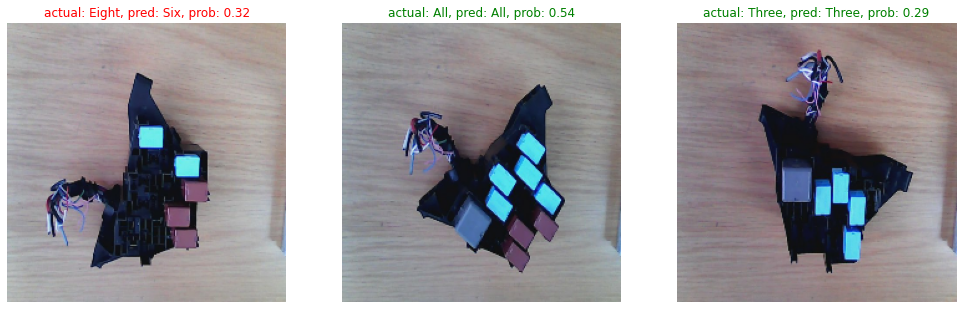

In [17]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
class_names = test_data.class_names
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


In [18]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-30]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(lr=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [19]:

# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2= model_1.fit(train_data,
                       epochs=fine_tune_epochs,
                       validation_data=test_data,
                       initial_epoch=history_1.epoch[-1], # start from previous last epoch
                       validation_steps=int(len(test_data)))
                       #callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")]) # name experiment appropriately

Epoch 5/10
32/32 [==============================] - 15s 266ms/step - loss: 0.2930 - accuracy: 0.9430 - val_loss: 0.7147 - val_accuracy: 0.7773
Epoch 6/10
32/32 [==============================] - 7s 204ms/step - loss: 0.1368 - accuracy: 0.9660 - val_loss: 0.6370 - val_accuracy: 0.8091
Epoch 7/10
32/32 [==============================] - 6s 184ms/step - loss: 0.0570 - accuracy: 0.9910 - val_loss: 0.6447 - val_accuracy: 0.8182
Epoch 8/10
32/32 [==============================] - 6s 185ms/step - loss: 0.0485 - accuracy: 0.9850 - val_loss: 0.7395 - val_accuracy: 0.7909
Epoch 9/10
32/32 [==============================] - 7s 197ms/step - loss: 0.0292 - accuracy: 0.9970 - val_loss: 0.7107 - val_accuracy: 0.8091
Epoch 10/10
32/32 [==============================] - 7s 222ms/step - loss: 0.0305 - accuracy: 0.9940 - val_loss: 0.7586 - val_accuracy: 0.8045


Increasing epochs further had no effect. 
Learning rate of 0.0001 was optimal, better than 0.001


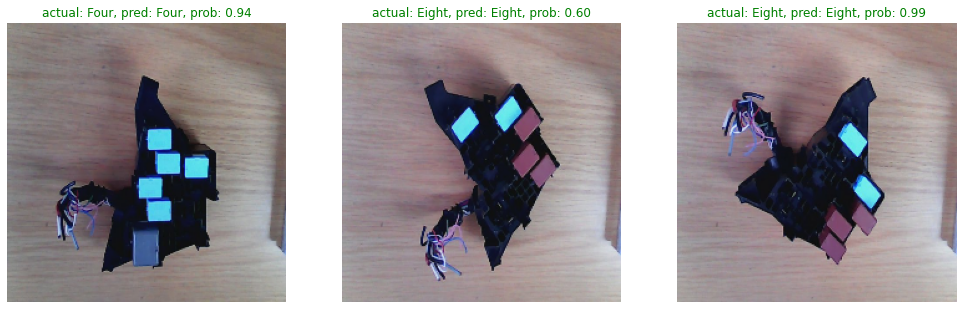

In [40]:
# Make preds on a series of random images
import os
import random

plt.figure(figsize=(17, 10))
class_names = test_data.class_names
for i in range(3):
  # Choose a random image from a random class 
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False) # don't scale images for EfficientNet predictions
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # model accepts tensors of shape [None, 224, 224, 3]
  pred_class = class_names[pred_prob.argmax()] # find the predicted class 

  # Plot the image(s)
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);


In [21]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

5
11
[0.39399999380111694, 0.7039999961853027, 0.8339999914169312, 0.890999972820282, 0.9390000104904175, 0.9430000185966492, 0.9660000205039978, 0.9909999966621399, 0.9850000143051147, 0.996999979019165, 0.9940000176429749]


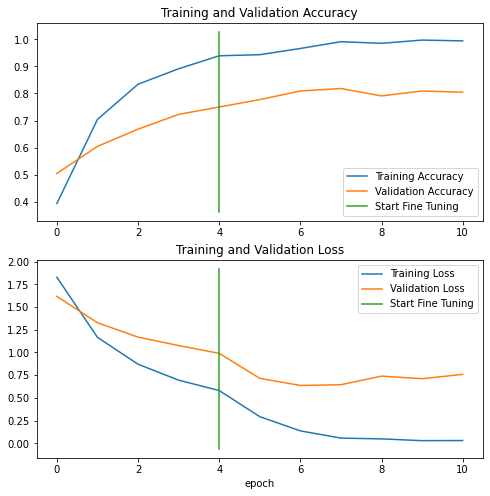

In [22]:
compare_historys(original_history=history_1, 
                 new_history=history_2, 
                 initial_epochs=5)

Validation accuracy seems to have plateud, need to investigate how to improve model further. Should more pictures be taken?

What if orientation did not change? Would we achieve 100% accuracy? 